# Social Network Analysis. Predict salary and new connections 

**Predicting missing salaries and new email connections from a company's email network**

**Network Analysis. Supervised Learning. Regression (Salary prediction) and Classification (New connections prediction)**


Data from [Applied Social Network Analysis in Python | Coursera](https://www.coursera.org/learn/python-social-network-analysis/):

`net_emails.txt`: network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people. 
The network also contains the node attributes Department (*name*) and ManagementSalary (1 = Receiving a management salary)

`net_future_connections.csv`: future conections of pair of nodes currently unconnected (1 = an edge between those two nodes will exist in the future)



**Note: The input data contains an old pickled networkx object. The required environment here is Python<=3.8  with networkx==1.11**


In [1]:
!pip install -q networkx==1.11

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import networkx as nx

sys.path.append("../")
import ds_boost

ds_boost.set_parent_execution_path()
ds_boost.info_system()

Path changed to /home/angel/DRIVE/data-science-keras

HARDWARE:
CPU:	Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
RAM:	8 GB
-- No GPU  --

OS:	Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.17

ENV:	/home/angel/miniconda3/envs/p38

PYTHON:	3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
tensorflow                    2.9.1
pandas                        1.4.3
numpy                        1.23.1

EXECUTION PATH: /home/angel/DRIVE/data-science-keras
EXECUTION DATE: Mon Aug 15 14:13:32 2022


# A. Salary Prediction

## A1. Data Processing

#### Load graph 

In [3]:
# Note: net_emails.txt is contains pickled networkx graph from an obsolete version of networkx (<2.0) with compatibility
#  issues with Python >3.8
graph = nx.read_gpickle("data/net_emails.txt")
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


#### Extract node attributes and features to a dataframe

In [4]:
graph.nodes(data=True)[:3]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan})]

In [5]:
# Dataframe with node attributes
df = pd.DataFrame(index=graph.nodes())  # df: complete df
attributes = [k for k in graph.nodes(data=True)[0][1]]
for a in attributes:
    df[a] = pd.Series(nx.get_node_attributes(graph, a))

# node features
df["clustering"] = pd.Series(nx.clustering(graph))
df["degree"] = pd.Series(graph.degree())

df.head()

,Department,ManagementSalary,clustering,degree
0,1,0.0,0.276423,44
1,1,NaN,0.265306,52
2,21,NaN,0.297803,95
3,21,1.0,0.384910,71
4,21,1.0,0.318691,96


#### Explore the target and separate the prediction set

In [6]:
target = ["ManagementSalary"]
features = [col for col in df if col not in target]

print(df[target].squeeze().value_counts(dropna=False))

0.0    634
NaN    252
1.0    119
Name: ManagementSalary, dtype: int64


In [7]:
n_rows_original = df.shape[0]

df_pred = df[df["ManagementSalary"].isnull()]
df = df[(df["ManagementSalary"] == 0) | (df["ManagementSalary"] == 1)]

assert df.shape[0], df_pred.shape[0] == n_rows_original

#### Split data into training and test set

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=0)

del df

`df_pred`: prediction set (no labels) <br>
`df_train`: training_set  <br>
`df_test`: test_set  <br>

#### Classify features
Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [9]:
import ds_boost

cat = ["Department", "ManagementSalary"]
num = ["clustering", "degree"]

df_train = ds_boost.sort_columns_by_type(df_train, target, categorical=cat)

pd.DataFrame(dict(df_train.dtypes), index=["Type"])[df_train.columns].head()

2 numerical features: 	 ['clustering', 'degree']
1 categorical features: 	 ['Department']
Target: 		ManagementSalary (category)


,clustering,degree,Department,ManagementSalary
Type,float32,float32,category,category


In [10]:
# df_train, dict_categories = ds_boost.remove_categories(df_train, target, ratio=0.01, show=True,
#                                                      dict_categories=None)

### Show training data

#### Numerical Features

In [11]:
df_train[num].describe(percentiles=[0.5])

,clustering,degree
count,602.000000,602.000000
mean,0.399478,33.318935
std,0.256666,38.390644
min,0.000000,1.000000
50%,0.377350,22.000000
max,1.000000,347.000000


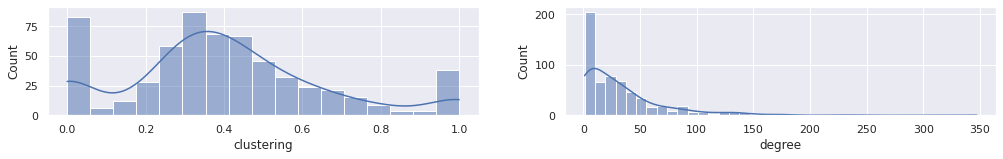

In [12]:
ds_boost.show_numerical(df_train[num], kde=True)

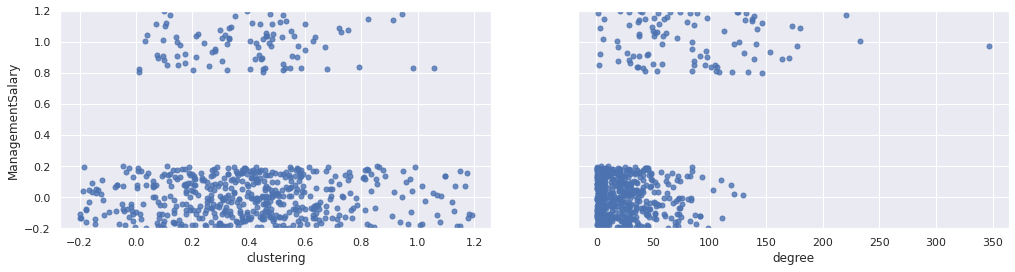

In [13]:
ds_boost.show_target_vs_numerical(df_train, target, jitter=0.2, fit_reg=False, point_size=100)

[]

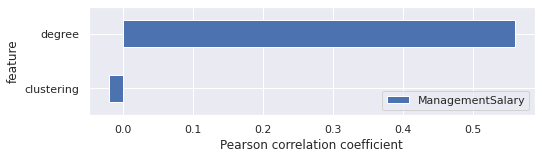

In [14]:
ds_boost.correlation(df_train, target)

#### Categorical Features

In [15]:
df_train[cat].describe()

,Department,ManagementSalary
count,602,602.0
unique,41,2.0
top,4,0.0
freq,70,507.0


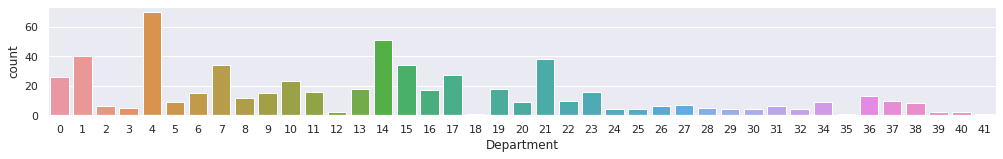

In [16]:
ds_boost.show_categorical(df_train[cat], target, sharey=True)

In [17]:
# ds_boost.show_target_vs_categorical(df_train, target)

#### Missing values

In [18]:
high_missing = ds_boost.missing(df_train, limit=0.4)
# ds_boost.fill_simple(df_train, target, missing_categorical=999, inplace=True)

No missing values found


In [19]:
copy_df = df_train.copy()  # checkpoint
del df_train

## A2. Neural Network

In [20]:
df_train = copy_df.copy()  # Restore checkpoint
data = df_train.copy()
# from now on use data instead of df

### Prepare data for Neural Network

#### Scale numerical variables

In [21]:
data, scale_param = ds_boost.scale(data)

#### Create dummy features

In [22]:
# features only; target encoded later
data, dict_dummies = ds_boost.replace_by_dummies(data, target)

# save features order for tests and predictions
model_features = [f for f in data if f not in target]

data.head(3)

,clustering,degree,ManagementSalary,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,...,Department_31,Department_32,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41
620,2.339707,-0.763700,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,-0.327388,0.356365,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688,-1.556415,-0.841844,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Split the data into training and validation sets

In [23]:
def validation_split(data, val_size=0.15):

    train, val = train_test_split(data, test_size=val_size, random_state=0, shuffle=True, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = val.drop(target, axis=1).values, val[target].values

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=0.2)

#### One-hot encode the output

In [24]:
import keras


def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

In [25]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))

train size 	 X:(481, 43) 	 Y:(481, 2)
val size 	 X:(121, 43) 	 Y:(121, 2)


### Build the Neural Network

In [26]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras import regularizers


def build_nn_binary_classification(input_size, output_size, summary=False):

    input_nodes = input_size // 8

    model = Sequential()
    model.add(Dense(input_nodes, input_dim=input_size, kernel_regularizer=regularizers.l2(0.001)))

    model.add(Dense(output_size, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    if summary:
        model.summary()

    return model


build_nn = build_nn_binary_classification

### Train the Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 220       
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 3.6 s


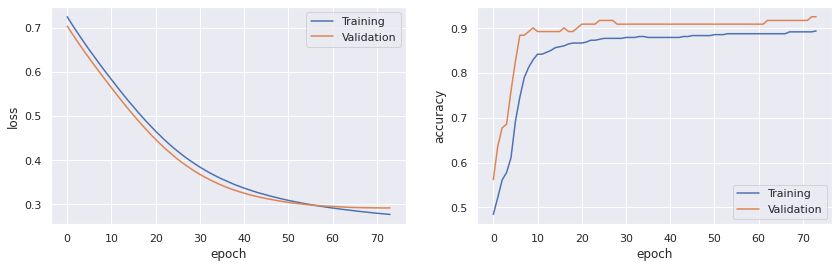


Training loss:  	0.2769
Validation loss: 	 0.2917

Training accuracy: 	0.894
Validation accuracy:	0.926


In [27]:
import os
from time import time


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """

    if show:
        print("Training ....")

    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=1, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=200,
        batch_size=64,
        verbose=0,
        validation_data=validation_data,
        # class_weight=cw, # worse results
        callbacks=callbacks,
    )

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        ds_boost.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn_binary_classification(x_train.shape[1], y_train.shape[1], summary=True)
train_nn(model, x_train, y_train, validation_data=(x_val, y_val));

### Evaluate the Model

In [28]:
data_test = ds_boost.sort_columns_by_type(df_test, target, categorical=cat)
data_test, _ = ds_boost.scale(data_test, scale_param)
data_test, _ = ds_boost.replace_by_dummies(data_test, target, dict_dummies)
data_test = data_test[model_features + target]  # sort columns to match training features order
x_test, y_test = data_test.drop(target, axis=1).values, data_test[target].values
y_test = keras.utils.to_categorical(y_test, 2)

2 numerical features: 	 ['clustering', 'degree']
1 categorical features: 	 ['Department']
Target: 		ManagementSalary (category)


In [29]:
from sklearn.metrics import roc_auc_score

score = model.evaluate(x_test, y_test, verbose=0)
print("\nNeural Network Accuracy: {:.3f}\n".format(score[1]))

y_pred = model.predict(x_test)

print("Neural Network ROC AUC:  {:.3f} \n".format(roc_auc_score(y_test, y_pred)))


Neural Network Accuracy: 0.868

5/5 [==============================] - 0s 2ms/step
Neural Network ROC AUC:  0.840 



## A3. Compare with non-neural network models

In [30]:
y_train = y_train[:, 1]
y_test = y_test[:, 1]

In [31]:
# from sklearn.utils import class_weight
# y_plain = np.ravel(y_train)
# cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)
# cw = {idx : value for idx, value in enumerate(cw)}

In [32]:
ds_boost.ml_classification(x_train, y_train, x_test, y_test, cross_validation=False)

Naive Bayes
Random Forest
Extremely Randomized Trees
LGBM


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
LGBM,0.10,0.36,0.91,0.81,0.54,0.82,0.65
Random Forest,0.21,0.32,0.88,0.71,0.42,0.83,0.53
Extremely Randomized Trees,0.17,0.37,0.86,0.62,0.33,0.79,0.43
Naive Bayes,0.00,25.16,0.27,0.17,0.96,0.55,0.29


# B. Future Connection Prediction

## B1. Data Processing

In [33]:
del df_train, df_test, df_pred

In [34]:
df = pd.read_csv("data/net_future_connections.csv", index_col=0, converters={0: eval})
df.head(6)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0


#### Extract edge-based attributes from the above graph

In [35]:
df["Common Neighbors"] = df.index.map(lambda city: len(list(nx.common_neighbors(graph, city[0], city[1]))))
df["Jaccard Coefficient"] = [i[2] for i in nx.jaccard_coefficient(graph, df.index)]
df["ResourceWarningurce Allocation"] = [i[2] for i in nx.resource_allocation_index(graph, df.index)]
df["Adamic-Adar Index"] = [i[2] for i in nx.adamic_adar_index(graph, df.index)]
df["Preferential Attachment"] = [i[2] for i in nx.preferential_attachment(graph, df.index)]
df.head()

,Future Connection,Common Neighbors,Jaccard Coefficient,ResourceWarningurce Allocation,Adamic-Adar Index,Preferential Attachment
"(6, 840)",0.0,9,0.073770,0.136721,2.110314,2070
"(4, 197)",0.0,2,0.015504,0.008437,0.363528,3552
"(620, 979)",0.0,0,0.000000,0.000000,0.000000,28
"(519, 872)",0.0,2,0.060606,0.039726,0.507553,299
"(382, 423)",0.0,0,0.000000,0.000000,0.000000,205


#### Explore the target and separate the prediction set

In [36]:
target = ["Future Connection"]
features = [col for col in df if col not in target]

df["Future Connection"].value_counts(dropna=False)

0.0    337002
NaN    122112
1.0     29332
Name: Future Connection, dtype: int64

In [37]:
n_rows_original = df.shape[0]

df_pred = df[df["Future Connection"].isnull()]
df = df[(df["Future Connection"] == 0) | (df["Future Connection"] == 1)]

assert df.shape[0], df_pred.shape[0] == n_rows_original

#### Split data into training and test set

In [38]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=0)

del df

`df_pred`: prediction set (no labels) <br>
`df_train`: training_set  <br>
`df_test`: test_set  <br>

#### Classify features
Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [39]:
import ds_boost

cat = ["Future Connection"]
num = features  # all the features are numerical here

df_train = ds_boost.sort_columns_by_type(df_train, target, categorical=cat)

pd.DataFrame(dict(df_train.dtypes), index=["Type"])[df_train.columns].head()

5 numerical features: 	 ['Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar Index', 'Preferential Attachment', 'ResourceWarningurce Allocation']
0 categorical features: 	 []
Target: 		Future Connection (category)


,Common Neighbors,Jaccard Coefficient,Adamic-Adar Index,Preferential Attachment,ResourceWarningurce Allocation,Future Connection
Type,float32,float32,float32,float32,float32,category


### Show training data

#### Numerical Features

In [40]:
df_train[num].describe(percentiles=[0.5])

,Common Neighbors,Jaccard Coefficient,ResourceWarningurce Allocation,Adamic-Adar Index,Preferential Attachment
count,293067.000000,293067.000000,293067.000000,293067.000000,293067.000000
mean,1.769438,0.019903,0.020300,0.384772,948.750488
std,4.009771,0.037289,0.053481,0.890036,1735.908569
min,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,304.000000
max,161.000000,1.000000,3.354600,40.304028,75646.000000


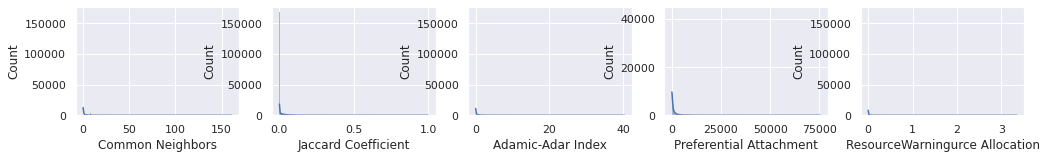

In [41]:
ds_boost.show_numerical(df_train, kde=True)

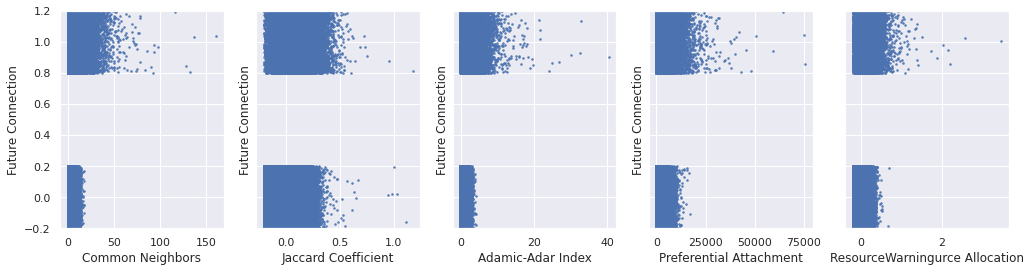

In [42]:
ds_boost.show_target_vs_numerical(df_train, target, jitter=0.2, fit_reg=False, point_size=10)

[]

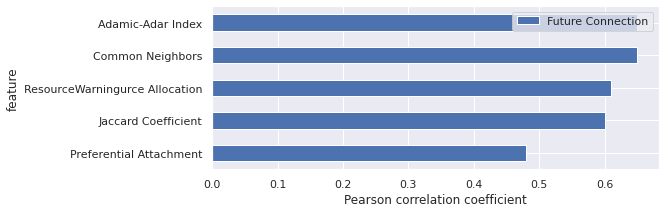

In [43]:
ds_boost.correlation(df_train, target)

#### Missing values

In [44]:
high_missing = ds_boost.missing(df_train, limit=0.4)

No missing values found


In [45]:
copy_df = df_train.copy()  # checkpoint
del df_train

## B2. Neural Network

In [46]:
df_train = copy_df.copy()  # Restore checkpoint
data = df_train.copy()
# from now on use data instead of df

### Prepare data for Neural Network

#### Scale numerical variables

In [47]:
data, scale_param = ds_boost.scale(data)

model_features = [f for f in data if f not in target]

#### Split the data into training and validation sets

In [48]:
def validation_split(data, val_size=0.15):

    train, val = train_test_split(data, test_size=val_size, random_state=0, shuffle=True, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = val.drop(target, axis=1).values, val[target].values

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=0.2)

#### One-hot encode the output

In [49]:
import keras


def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

In [50]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))

train size 	 X:(234453, 5) 	 Y:(234453, 2)
val size 	 X:(58614, 5) 	 Y:(58614, 2)


### Build the Neural Network

In [51]:
def build_nn_binary_classification(input_size, output_size, summary=False):

    input_nodes = input_size

    model = Sequential()

    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            kernel_regularizer=regularizers.l2(0.0001),
        )
    )

    model.add(
        Dense(
            output_size,
            activation="softmax",
            kernel_regularizer=regularizers.l2(0.0001),
        )
    )

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    if summary:
        model.summary()

    return model


build_nn = build_nn_binary_classification

### Train the Neural Network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 1.8 s


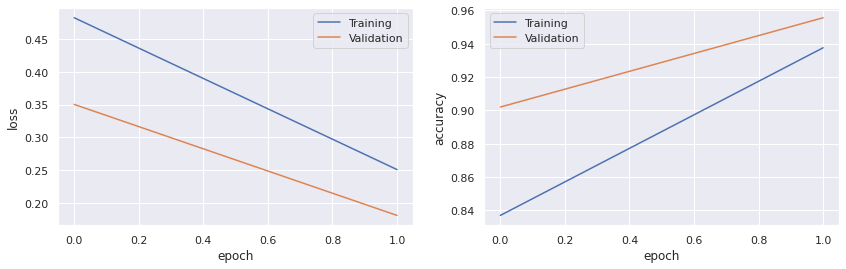


Training loss:  	0.2510
Validation loss: 	 0.1811

Training accuracy: 	0.938
Validation accuracy:	0.956


In [52]:
def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """
    Train the neural network model. If no validation_data is provided, a split for validation
    will be used
    """

    if show:
        print("Training ....")

    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=0, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=20,
        batch_size=1024,
        verbose=0,
        validation_data=validation_data,
        callbacks=callbacks,
    )

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        ds_boost.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn_binary_classification(x_train.shape[1], y_train.shape[1], summary=True)
train_nn(model, x_train, y_train, validation_data=(x_val, y_val));

### Evaluate the Model

In [53]:
data_test = ds_boost.sort_columns_by_type(df_test, target, categorical=cat)
data_test, _ = ds_boost.scale(data_test, scale_param)
data_test = data_test[model_features + target]  # sort columns to match training features order
x_test, y_test = data_test.drop(target, axis=1).values, data_test[target].values
y_test = keras.utils.to_categorical(y_test, 2)

5 numerical features: 	 ['Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar Index', 'Preferential Attachment', 'ResourceWarningurce Allocation']
0 categorical features: 	 []
Target: 		Future Connection (category)


In [54]:
from sklearn.metrics import roc_auc_score

score = model.evaluate(x_test, y_test, verbose=0)
print("\nNeural Network Accuracy: {:.3f}\n".format(score[1]))

y_pred = model.predict(x_test)

print("Neural Network ROC AUC:  {:.3f} \n".format(roc_auc_score(y_test, y_pred)))


Neural Network Accuracy: 0.955

2290/2290 [==============================] - 4s 2ms/step
Neural Network ROC AUC:  0.908 



## B3. Compare with non-neural network models

In [55]:
y_train = y_train[:, 1]
y_test = y_test[:, 1]

In [56]:
# from sklearn.ensemble import RandomForestClassifier
# clf=None
# clf = RandomForestClassifier()
# clf.fit(x_train, np.ravel(y_train))
# print("\nRandom Forest Accuracy: {:.3f}\n".format(clf.score(x_train, y_train)))
# y_pred = clf.predict_proba(x_test)
# print('Random Forest ROC_AUC: {:.3f}'.format(roc_auc_score(y_test, y_pred[:,1])))

In [57]:
ds_boost.ml_classification(x_train, y_train, x_test, y_test, cross_validation=False)

Naive Bayes
Random Forest
Extremely Randomized Trees
LGBM


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
LGBM,2.97,0.13,0.96,0.85,0.60,0.91,0.71
Extremely Randomized Trees,1.70,0.13,0.96,0.86,0.59,0.91,0.70
Random Forest,4.40,0.14,0.96,0.84,0.60,0.91,0.70
Naive Bayes,0.06,0.85,0.93,0.55,0.76,0.91,0.64
